<a href="https://colab.research.google.com/github/RAvila-bioeng/M.R.AI/blob/main/alzheimer's_resnet_sintruncar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle_API"

# Descargar dataset
!kaggle datasets download -d ninadaithal/imagesoasis

# Descomprimir
!unzip -q imagesoasis.zip

import os
print("Contenido del directorio actual:", os.listdir("."))
print("Contenido de 'Data' si existe:", os.listdir("Data") if os.path.exists("Data") else "No existe 'Data'")


Mounted at /content/gdrive
Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
100% 1.23G/1.23G [00:05<00:00, 225MB/s]
100% 1.23G/1.23G [00:05<00:00, 224MB/s]
Contenido del directorio actual: ['.config', 'imagesoasis.zip', 'Data', 'gdrive', 'sample_data']
Contenido de 'Data' si existe: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']


In [ ]:
import os
import shutil
import random
from collections import defaultdict

original_dir = "./Data"
assert os.path.exists(original_dir), "No existe ./Data. Revisa la celda 1."

subset_dir = "./Data_subset"

# Empezar *limpio*
if os.path.exists(subset_dir):
    shutil.rmtree(subset_dir)
os.makedirs(subset_dir, exist_ok=True)

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
N_PATIENTS_NON_DEMENTED = 120  # nº máximo de pacientes sanos

classes = [d for d in os.listdir(original_dir)
           if os.path.isdir(os.path.join(original_dir, d))]
print("Clases encontradas en Data:", classes)

for cls in classes:
    src_cls_dir = os.path.join(original_dir, cls)
    dst_cls_dir = os.path.join(subset_dir, cls)
    os.makedirs(dst_cls_dir, exist_ok=True)

    print(f"\nProcesando clase: {cls}")

    if "non" not in cls.lower():   # todas menos Non Demented
        imgs = [f for f in os.listdir(src_cls_dir)
                if f.lower().endswith(valid_exts)]
        print(f"  Copiando TODAS las imágenes ({len(imgs)})...")
        for fname in imgs:
            shutil.copy2(os.path.join(src_cls_dir, fname),
                         os.path.join(dst_cls_dir, fname))

    else:
        # Non Demented: reducir por nº de pacientes
        imgs = [f for f in os.listdir(src_cls_dir)
                if f.lower().endswith(valid_exts)]
        print(f"  Imágenes totales en {cls}: {len(imgs)}")
        print("  Ejemplos de nombres:", imgs[:5])

        images_by_patient = defaultdict(list)
        for fname in imgs:
            parts = fname.split('_')
            # OAS1_0097_MR1_mpr-3_127.jpg → paciente = "OAS1_0097"
            patient_id = "_".join(parts[:2]) if len(parts) >= 2 else parts[0]
            images_by_patient[patient_id].append(fname)

        print(f"  Pacientes totales detectados: {len(images_by_patient)}")

        patients = list(images_by_patient.keys())
        n_keep = min(N_PATIENTS_NON_DEMENTED, len(patients))
        selected_patients = random.sample(patients, n_keep)

        print(f"  Pacientes que vamos a conservar en {cls}: {n_keep}")

        count_imgs = 0
        for pid in selected_patients:
            for fname in images_by_patient[pid]:
                shutil.copy2(os.path.join(src_cls_dir, fname),
                             os.path.join(dst_cls_dir, fname))
                count_imgs += 1

        print(f"  Imágenes copiadas en {cls} (subset): {count_imgs}")

print("\n✅ Data_subset creado en:", subset_dir)

# Comprobar conteos
for cls in os.listdir(subset_dir):
    cls_path = os.path.join(subset_dir, cls)
    if os.path.isdir(cls_path):
        n = len([f for f in os.listdir(cls_path)
                 if f.lower().endswith(valid_exts)])
        print(f"{cls}: {n} imágenes en Data_subset")


Clases encontradas en Data: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']

Procesando clase: Non Demented
  Imágenes totales en Non Demented: 67222
  Ejemplos de nombres: ['OAS1_0277_MR1_mpr-2_147.jpg', 'OAS1_0001_MR1_mpr-4_118.jpg', 'OAS1_0249_MR2_mpr-3_115.jpg', 'OAS1_0058_MR1_mpr-2_152.jpg', 'OAS1_0121_MR1_mpr-1_127.jpg']
  Pacientes totales detectados: 266
  Pacientes que vamos a conservar en Non Demented: 120
  Imágenes copiadas en Non Demented (subset): 30866

Procesando clase: Very mild Dementia
  Copiando TODAS las imágenes (13725)...

Procesando clase: Moderate Dementia
  Copiando TODAS las imágenes (488)...

Procesando clase: Mild Dementia
  Copiando TODAS las imágenes (5002)...

✅ Data_subset creado en: ./Data_subset
Non Demented: 30866 imágenes en Data_subset
Very mild Dementia: 13725 imágenes en Data_subset
Moderate Dementia: 488 imágenes en Data_subset
Mild Dementia: 5002 imágenes en Data_subset


In [ ]:
import os
import shutil
import random
from collections import defaultdict

# Directorio de entrada (ya balanceado por pacientes sanos)
subset_dir = "./Data_subset"

# Nuevo directorio de salida para el split binario
split_root = "./Data_split_2cls"
os.makedirs(split_root, exist_ok=True)

# Mapa de clases original -> clase lógica binaria
CLASS_MAP = {
    "Non Demented": "Non Demented",
    "Very mild Dementia": "Demented",
    "Mild Dementia": "Demented",
    "Moderate Dementia": "Demented",
}

logical_classes = sorted(set(CLASS_MAP.values()))
print("Logical classes:", logical_classes)

# Crear estructura de carpetas: train/val/test + clases
for split in ["train", "val", "test"]:
    for cls in logical_classes:
        os.makedirs(os.path.join(split_root, split, cls), exist_ok=True)

# Agrupar imágenes por (clase lógica, paciente)
class_patient_images = {cls: defaultdict(list) for cls in logical_classes}

for orig_class in os.listdir(subset_dir):
    orig_class_path = os.path.join(subset_dir, orig_class)
    if not os.path.isdir(orig_class_path):
        continue

    if orig_class not in CLASS_MAP:
        print(f"Saltando clase desconocida: {orig_class}")
        continue

    logical_class = CLASS_MAP[orig_class]

    for fname in os.listdir(orig_class_path):
        fpath = os.path.join(orig_class_path, fname)
        if not os.path.isfile(fpath):
            continue

        # Filtrar solo imágenes
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Extraer patient_id del nombre de archivo (adaptado al patrón OASIS)
        parts = fname.split("_")
        if len(parts) >= 2 and parts[0].startswith("OAS1"):
            patient_id = parts[0] + "_" + parts[1]
        else:
            # Fallback por si acaso
            patient_id = parts[0]

        class_patient_images[logical_class][patient_id].append(fpath)

# Función para hacer split por pacientes
def split_patients(patients, train_ratio=0.7, val_ratio=0.15, seed=42):
    random.seed(seed)
    patients = list(patients)
    random.shuffle(patients)

    n = len(patients)
    if n == 0:
        return [], [], []

    n_train = max(1, int(train_ratio * n))
    n_val = max(1, int(val_ratio * n))
    n_test = n - n_train - n_val

    # Ajustes por si n_test queda a 0
    if n_test <= 0:
        n_test = 1
        if n_val > 1:
            n_val -= 1
        else:
            n_train = max(1, n_train - 1)

    train_patients = patients[:n_train]
    val_patients = patients[n_train:n_train + n_val]
    test_patients = patients[n_train + n_val:]

    return train_patients, val_patients, test_patients

# Hacer el split y copiar archivos
for logical_class in logical_classes:
    patients_dict = class_patient_images[logical_class]
    patients = list(patients_dict.keys())
    print(f"\nClase '{logical_class}': {len(patients)} pacientes")

    train_p, val_p, test_p = split_patients(patients)

    print(f"  Train: {len(train_p)} pacientes")
    print(f"  Val:   {len(val_p)} pacientes")
    print(f"  Test:  {len(test_p)} pacientes")

    for split_name, split_pat_list in [("train", train_p),
                                       ("val", val_p),
                                       ("test", test_p)]:
        for pid in split_pat_list:
            for src_path in patients_dict[pid]:
                dst_path = os.path.join(
                    split_root,
                    split_name,
                    logical_class,
                    os.path.basename(src_path),
                )
                shutil.copy2(src_path, dst_path)

print("\nCopiado terminado. Comprobando número de imágenes por split y clase...\n")

# Comprobación final de conteos
for split in ["train", "val", "test"]:
    print(f"Split: {split}")
    for cls in logical_classes:
        cls_dir = os.path.join(split_root, split, cls)
        if not os.path.isdir(cls_dir):
            print(f"  {cls}: 0 imágenes (directorio no encontrado)")
            continue
        n_images = sum(
            1 for f in os.listdir(cls_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        )
        print(f"  {cls}: {n_images} imágenes")
    print()


Logical classes: ['Demented', 'Non Demented']

Clase 'Demented': 81 pacientes
  Train: 56 pacientes
  Val:   12 pacientes
  Test:  13 pacientes

Clase 'Non Demented': 120 pacientes
  Train: 84 pacientes
  Val:   18 pacientes
  Test:  18 pacientes

Copiado terminado. Comprobando número de imágenes por split y clase...

Split: train
  Demented: 13359 imágenes
  Non Demented: 21045 imágenes

Split: val
  Demented: 2745 imágenes
  Non Demented: 4514 imágenes

Split: test
  Demented: 3111 imágenes
  Non Demented: 5307 imágenes



In [ ]:
for split in ["train", "val", "test"]:
    print(f"\n=== {split.upper()} ===")
    split_dir = os.path.join(split_root, split)
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        if os.path.isdir(cls_path):
            n = len([f for f in os.listdir(cls_path)
                     if f.lower().endswith(valid_exts)])
            print(f"  {cls}: {n} imágenes")



=== TRAIN ===
  Non Demented: 21045 imágenes
  Demented: 13359 imágenes

=== VAL ===
  Non Demented: 4514 imágenes
  Demented: 2745 imágenes

=== TEST ===
  Non Demented: 5307 imágenes
  Demented: 3111 imágenes


In [ ]:
!pip install -q torch torchvision scikit-learn

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Semillas (opcional pero recomendable)
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_root = "./Data_split_2cls"

# Transformaciones
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),  # en RM suele ser razonable
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_dataset = datasets.ImageFolder(os.path.join(data_root, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_root, "val"),   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_root, "test"),  transform=val_test_transform)

class_names = train_dataset.classes
print("Class to index mapping:", train_dataset.class_to_idx)
print("Classes:", class_names)

batch_size = 64  # puedes subirlo a 64 si la GPU aguanta

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Class to index mapping: {'Demented': 0, 'Non Demented': 1}
Classes: ['Demented', 'Non Demented']


In [ ]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Cargar ResNet18 preentrenada
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar TODAS las capas primero
for param in resnet18.parameters():
    param.requires_grad = False

# Descongelar solo el último bloque (layer4) + la FC
for param in resnet18.layer4.parameters():
    param.requires_grad = True

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2)
)

resnet18 = resnet18.to(device)


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


In [ ]:
import numpy as np
import torch

# Calcular pesos de clase (inversamente proporcionales a la frecuencia)
targets = [s[1] for s in train_dataset.samples]
class_counts = np.bincount(targets)
print("Train class counts:", class_counts)

class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)  # normaliza un poco
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# AdamW con regularización L2 (weight_decay)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, resnet18.parameters()),
    lr=1e-4,
    weight_decay=1e-2
)

# Scheduler: reduce LR cuando la val_loss deja de mejorar
# Scheduler: reduce LR cuando la val_loss deja de mejorar
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.3,
    patience=2
)



Train class counts: [13359 21045]
Class weights: [1.22340426 0.77659574]


In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader,
                num_epochs=25, patience=5):
    best_val_acc = 0.0
    best_state_dict = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # ---------- Entrenamiento ----------
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            # opcional: clip de gradiente para más estabilidad
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total

        # ---------- Validación ----------
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels).item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc  = val_corrects / val_total

        # Scheduler usa la pérdida de validación
        scheduler.step(val_loss)

        print(f"Train Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

        # Guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = model.state_dict().copy()
            epochs_no_improve = 0
            print("  --> New best model!")
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epoch(s)")

        # Early stopping
        if epochs_no_improve >= patience:
            print("\nEarly stopping triggered.")
            break

    print(f"\nBest val accuracy: {best_val_acc:.4f}")
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model

# Entrenar
resnet18 = train_model(
    resnet18, criterion, optimizer, scheduler,
    train_loader, val_loader,
    num_epochs=25, patience=5
)



Epoch 1/25
------------------------------
Train Loss: 0.3273  Acc: 0.8485
Val   Loss: 0.5393  Acc: 0.8131
  --> New best model!

Epoch 2/25
------------------------------
Train Loss: 0.1600  Acc: 0.9332
Val   Loss: 0.6618  Acc: 0.8268
  --> New best model!

Epoch 3/25
------------------------------
Train Loss: 0.1021  Acc: 0.9599
Val   Loss: 0.7818  Acc: 0.8274
  --> New best model!

Epoch 4/25
------------------------------
Train Loss: 0.0727  Acc: 0.9723
Val   Loss: 0.8894  Acc: 0.8059
  No improvement for 1 epoch(s)

Epoch 5/25
------------------------------
Train Loss: 0.0443  Acc: 0.9829
Val   Loss: 0.7409  Acc: 0.8420
  --> New best model!

Epoch 6/25
------------------------------
Train Loss: 0.0350  Acc: 0.9876
Val   Loss: 0.7053  Acc: 0.8461
  --> New best model!

Epoch 7/25
------------------------------
Train Loss: 0.0301  Acc: 0.9893
Val   Loss: 0.7584  Acc: 0.8478
  --> New best model!

Epoch 8/25
------------------------------
Train Loss: 0.0252  Acc: 0.9913
Val   Loss: 

Test accuracy: 0.7920
Confusion matrix (raw counts):
[[2170  941]
 [ 810 4497]]


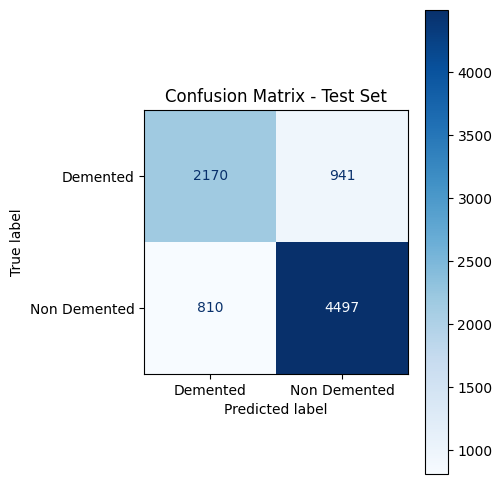

In [ ]:
resnet18.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Métricas básicas
test_acc = (all_preds == all_labels).mean()
print(f"Test accuracy: {test_acc:.4f}")

# -------- Matriz de confusión --------
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix (raw counts):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
